# Test di Pearson per i dati della stazione di Pian di Fedaia (diga)

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

In [2]:
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

In [3]:
os_DatiFedaia=os.getcwd()
os.chdir(os_DatiFedaia)

In [4]:
data=pd.read_csv('DatiFedaiaSub.csv')
map(datetime,data['Anno'])
data=data.set_index('Anno')
lst=data.columns #['1h','3h','6h','12h','24h']

#### Lista contente gli intervalli di durata

In [5]:
h=[]
for i in range(len(data.columns)):
    h.append(data.columns[i])

In [6]:
data

,15min,30min,45min,1ora,3ore,6ore,12ore,24ore,1giorno,2giorni,3giorni,4giorni,5giorni
Anno,,,,,,,,,,,,,
1919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,6.4,8.6,10.2,12.6,32.2,43.8,48.6,57.0,50.4,75.0,79.2,81.0,87.8
2008,18.2,30.0,37.2,40.0,50.8,61.2,83.4,91.8,NaN,NaN,NaN,NaN,NaN


### Si importano le coppie di parametri ricavate con i precedenti metodi
#### Momenti, Massima Verosimiglianza, Minimi Quadrati

In [7]:
abs_m=pd.read_pickle("abs_m")
abs_mle=pd.read_pickle("abs_mle")
abs_mq=pd.read_pickle("abs_mq")

### Funzione del chi quadro

In [8]:
def X2(data,abs_t,h,delta):
    dt=data[h].dropna()
    
    lh=len(dt)
    
    q=[delta*(i+1) for i in range(int(1/delta))]
    
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    
    o0=lh*r
    
    o=o0-np.append([0],np.delete(o0,-1))
    
    e=[delta*lh for i in range(len(r))]
    
    return ((o-e)**2/e).sum() 

In [9]:
abs_=['abs_m','abs_mq','abs_mle']

### Viene calcolato il chi quadro dei parametri per i vari metodi utilizzati in precedenza

In [10]:
a=[]
for i in h:
    a=a+[[X2(data,abs_m,i,0.2),X2(data,abs_mq,i,0.2),X2(data,abs_mle,i,0.2)]] #0.2 è l'intervallo di probabilità cioè 1/k in questo caso k=5

param=pd.DataFrame(a,index=h,columns=abs_)
param

,abs_m,abs_mq,abs_mle
15min,3.354839,5.935484,2.387097
30min,4.645161,0.774194,0.774194
45min,11.600000,4.000000,7.600000
1ora,6.651163,2.697674,6.418605
3ore,4.093023,4.790698,4.093023
6ore,12.697674,12.232558,10.604651
12ore,3.238095,3.714286,3.714286
24ore,7.116279,5.953488,3.395349
1giorno,4.384615,2.076923,4.384615
2giorni,0.923077,2.076923,0.923077


### Viene selezionato per ogni intervallo di tempo il metodo che risulta avere il chi quadro minore 

In [11]:
def migliore(df,l):
    par=df.T

    b={}
    for i in l:
        if par[i][1]<=par[i][2]:
            best=par.index[1]
            be=par[i][1]
        
        if par[i][1]>par[i][2]:
            best=par.index[2]
            be=par[i][2]
        
        
        if par[i][1]>=par[i][0]:
            best=par.index[0]
            be=par[i][0]
        
        if be>=par[i][2]:
            best=par.index[2]
        
        be=0    
        b.update({i:best})
    return b

### Stampa dei risultati
#### Si noti che ad ogni intervallo orario corrisponde la coppia di parametri migliore

In [12]:
b=migliore(param,h)
b

{'15min': 'abs_mle',
 '30min': 'abs_mq',
 '45min': 'abs_mq',
 '1ora': 'abs_mq',
 '3ore': 'abs_mle',
 '6ore': 'abs_mle',
 '12ore': 'abs_m',
 '24ore': 'abs_mle',
 '1giorno': 'abs_mq',
 '2giorni': 'abs_mle',
 '3giorni': 'abs_mle',
 '4giorni': 'abs_m',
 '5giorni': 'abs_mle'}

### Si crea un dataframe con i parametri che per ogni intervallo mi da il chi quadro minore

In [13]:
best=DataFrame([abs_mle['15min'],
                abs_mq['30min'],
                abs_mq['45min'],
                abs_mq["1ora"],
                abs_mle["3ore"],
                abs_mle["6ore"],
                abs_m["12ore"],
                abs_mle["24ore"],
                abs_mq['1giorno'],
                abs_mle['2giorni'],
                abs_mle['3giorni'],
                abs_m['4giorni'],
                abs_mle['5giorni']]).T
                  
best

,15min,30min,45min,1ora,3ore,6ore,12ore,24ore,1giorno,2giorni,3giorni,4giorni,5giorni
a,7.968888,9.510462,10.926104,12.601354,22.728162,31.960715,48.746973,66.168039,61.988983,87.992147,98.215226,106.758154,111.564329
b,2.852050,2.721378,2.591708,3.002031,5.338338,9.341875,13.646262,24.067697,20.564437,24.175602,25.775174,29.724126,31.780342


### Salvo i parametri migliori in un file

In [14]:
best.to_pickle("best_param")

### Operazioni preliminari per graficare i risultati

#### Funzione delle curve di Gumbel

In [15]:
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))

#### Spazio lineare

In [16]:
minimo=min(data.min()) #7.2 questi dati valgono solo per le durate orarie di 1,3,6,12,24 ore
mass=max(data.max()) #132.6

t_rain=np.linspace(minimo,mass,100)

#### Dataframe con i dati per le curve di Gumbel

In [17]:
g=[]
for i in h:
    g.append(gumbel(t_rain,best,i))
    
gb=pd.DataFrame(g).T
gb.index=t_rain
gb.columns=h

#### Impostazioni dei grafici

In [18]:
SMALL_SIZE=15
MEDIUM_SIZE=20
BIGGER_SIZE=30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [19]:
import random
colors={}
c=[]
for i in h:
    colore=(random.random(), random.random(), random.random())
    colors.update({i:colore})
    c.append(colors[i])

#### Misure dell'ECDF

In [20]:
ecdf={}
for i in h:
    ecdf.update({i:ECDF(data[i].dropna())})

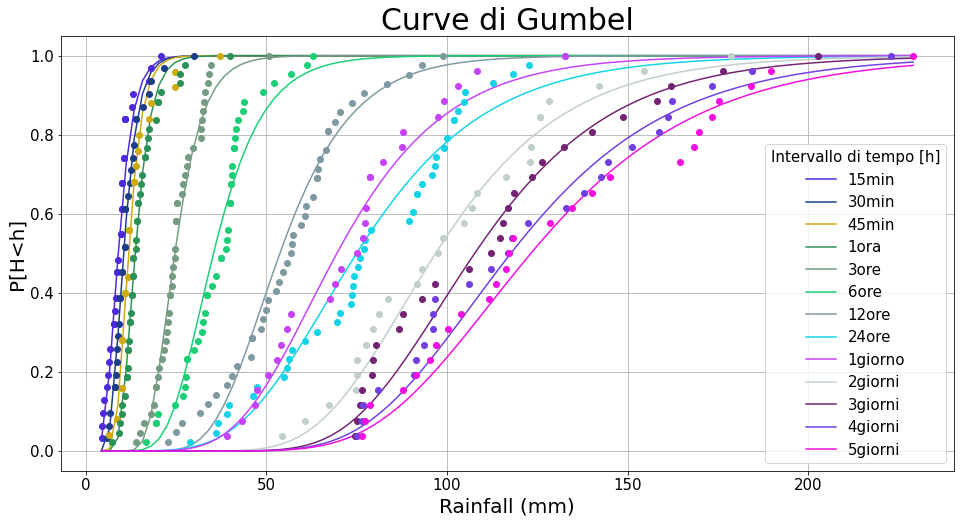

In [21]:
ax=gb.plot(figsize=(16,8),color=c)
for i in h:
    ax.plot(data[i].dropna(),ecdf[i](data[i].dropna()),'o',c=colors[i])
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P[H<h]')
ax.grid(True)
ax.legend (title= "Intervallo di tempo [h]")